In [0]:
# !pip uninstall tensorflow -y
# !pip install tensorflow

In [0]:
# Run this one if using google colab
from google.colab import drive
import sys
import os

drive.mount('/content/gdrive',True)
# sys.path.append("/content/xray_code/python_code")
sys.path.append("/content/gdrive/My Drive/xray_code/python_code")

if not os.path.exists("/content/xray_code"):
  !cp -r "/content/gdrive/My Drive/xray_code/" "/content/xray_code"

Mounted at /content/gdrive


In [0]:
%load_ext autoreload
%autoreload 2

from utils import *
from ml_utils import XrayTF
from tqdm import tqdm_notebook as tqdm
from threading import Thread
from constants import LOCAL_IMAGES_LOCATION

import pprint
import urllib.request as req
import matplotlib.pyplot as plt
import numpy as np
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load csv if exist, if not get the original one and parse it


In [0]:
"""
SICKNESS = "Infiltration"
SICKNESS = "Pneumonia"
SICKNESS = "Mass"
SICKNESS = "Pneumothorax"
"""

SICKNESS = "Pneumonia"
csv_file = "pneumonia_dataset.csv"
csv_file_full_path = f'/content/gdrive/My Drive/xray_code/sheet/{csv_file}'

IMAGE_SIZE = 512
BATCH_SIZE = 32
EPOCH = 100

# take existing if it exist
if os.path.exists(csv_file_full_path):
    df = pd.read_csv(csv_file_full_path)
    xray_class = XrayTF(df, IMAGE_SIZE, BATCH_SIZE)
    xray_class.prepend_image_full_path()
else:
    df = get_data_sheet()
    df = normalize_data_frame(df)
    xray_class = XrayTF(df, IMAGE_SIZE, BATCH_SIZE)
    xray_class.prepend_image_full_path()
    xray_class.df.to_csv(csv_file_full_path, index=False)

xray_class.df.head()

,Unnamed: 0,Image Index,labels,View Position
0,0,https://images.marknavalta.com/v0.1/IM-0001-00...,No Finding,PA
1,1,https://images.marknavalta.com/v0.1/IM-0003-00...,No Finding,PA
2,2,https://images.marknavalta.com/v0.1/IM-0005-00...,No Finding,PA
3,3,https://images.marknavalta.com/v0.1/IM-0006-00...,No Finding,PA
4,4,https://images.marknavalta.com/v0.1/IM-0007-00...,No Finding,PA


# Analyze our data set
- take a look at the distribution
- prepare data before splitting to test and train
  - Get image based on xray Position
  - Select a sickness and balance them
- Generate Age histogram

In [0]:
print(xray_class.df["View Position"].value_counts())
print("="*50)
print(xray_class.df.labels.value_counts())

PA    5856
Name: View Position, dtype: int64
Pneumonia     4273
No Finding    1583
Name: labels, dtype: int64


In [0]:
# Pick a sickness
xray_class.use_one_label("No Finding", balance=True)

# Verify how balanced our data is
print(xray_class.df.labels.value_counts())
# print(xray_class.df["Patient Gender"].value_counts())

Pneumonia     1583
No Finding    1583
Name: labels, dtype: int64


In [0]:
# xray_class.df["Patient Age"].hist(bins=30).set_xlim(0,100)

# Download our data
- Parallel download from digital ocean
- prepend system path after download

In [0]:
!rm -rf /content/images
if not os.path.exists(LOCAL_IMAGES_LOCATION):
  !mkdir /content/images

  class Downloader(Thread):
    def __init__(self, file_url, save_path):
        Thread.__init__(self)
        self.file_url = file_url
        self.save_path = save_path

    def run(self):
        remaining_download_tries = 15

        while remaining_download_tries > 0:
            try:
                req.urlretrieve(self.file_url, self.save_path)
                time.sleep(0.1)
            except:
                print("error downloading " + self.file_url +
                      " on trial no: " + str(16 - remaining_download_tries))
                remaining_download_tries = remaining_download_tries - 1
                continue
            else:
                break
  # xray_class.df["Image Index"].apply(lambda x: Downloader(x, LOCAL_IMAGES_LOCATION + x.split('/')[-1] ).start() )

  open_threads = [Downloader(x, LOCAL_IMAGES_LOCATION + x.split('/')[-1] ) for x in xray_class.df["Image Index"]]
  started_threads = [thread.start() for thread in open_threads]
  joined_threads = [thread.join() for thread in open_threads]

In [0]:
#  let's now append the full system path
xray_class.df["Image Index"] = xray_class.df["Image Index"].apply(lambda x : LOCAL_IMAGES_LOCATION + x.split('/')[-1])
xray_class.df.head()

,Unnamed: 0,Image Index,labels,View Position
3019,1436,/content/images/person158_bacteria_744.jpeg,Pneumonia,PA
2757,1174,/content/images/person1481_bacteria_3866.jpeg,Pneumonia,PA
1891,308,/content/images/person1147_virus_1917.jpeg,Pneumonia,PA
2906,1323,/content/images/person1535_virus_2672.jpeg,Pneumonia,PA
4419,2836,/content/images/person458_bacteria_1952.jpeg,Pneumonia,PA


# Pre-processing of images and label
- split dataframe accordingly with equal numbers of labels in test and train
- batches image
- show image

In [0]:
# Split them into training and validation using NUM_IMAGES 
train_df, valid_df, test_df = xray_class.get_test_train_split_data(len(xray_class.df))

print(train_df.labels.value_counts())
print("="*50)
print(valid_df.labels.value_counts())
print("="*50)
print(test_df.labels.value_counts())


No Finding    1266
Pneumonia     1266
Name: labels, dtype: int64
No Finding    254
Pneumonia     253
Name: labels, dtype: int64
Pneumonia     64
No Finding    63
Name: labels, dtype: int64


In [0]:
# Create training and validation data batches using ImageDataGenerator
train_data = xray_class.generate_image(train_df, True)
val_data   = xray_class.generate_image(valid_df)
test_data   = xray_class.generate_image(test_df)

Found 2532 validated image filenames belonging to 2 classes.
Found 507 validated image filenames belonging to 2 classes.
Found 127 validated image filenames belonging to 2 classes.


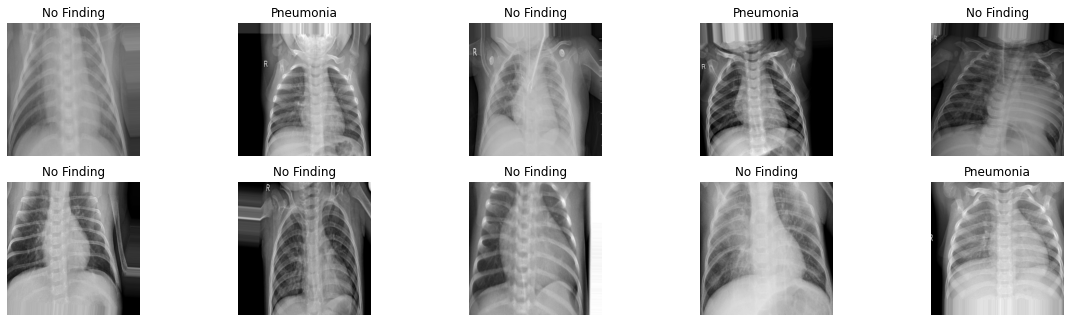

In [0]:
train_images, train_labels = next(train_data)
xray_class.show_25_images(train_images, train_labels)

# Perform model trainining
- fit our data using Categorical classification with metrics of accuracy and optimization Adam
- validate data
- save our model

In [14]:
result = xray_class.cross_validation(EPOCH, train_data, val_data, test_data)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              55875273  
_________________________________________________________________
dense (Dense)                (None, 512)               513024    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 56,389,323
Trainable params: 514,050
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 80 steps, validate for 16 steps
Epoch 1/100
80/80 [==============================] - 173s 2s/step - loss: 1.8191 - accuracy: 0.8002 - val_loss: 0.2805 - val_accuracy: 0.8817
Epoch 2/100
80/80 [==============================] - 161s 2s/step - loss: 0.3068 - accuracy: 0.8784 - val_loss: 0.2025 - val_accuracy: 0.9172
Epoch 3/100
80/80 [==============================] - 160s 2s/step - loss: 0.2975 - accuracy: 0.8839 - val_loss: 0.3792 - val_accuracy: 0.8205
Epoch 4/100
80/80 [==============================] - 159s 2s/step - loss: 0.2929 - accuracy: 0.8859 - val_loss: 0.2023 - val_accuracy: 0.9132
Epoch 5/100
80/80 [==============================] - 158s 2s/step - loss: 0.2878 - accuracy: 0.8803 - val_loss: 0.1354 - val_accuracy: 0.9428
Epoch 6/100
80/80 [==============================] - 157s 2s/step - loss: 0.2874 - accuracy: 0.8863 - val_loss: 0.2936 - val_accuracy: 0.8797
Epoch 7/100
80/80 [==============================] - 155s 2s/step - loss: 0.3051 - accuracy: 0.8803 - val_

  ...
    to  
  ['...']


4/4 [==============================] - 3s 868ms/step - loss: 0.2356 - accuracy: 0.9213
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              55875273  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               513024    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 56,389,323
Trainable params: 514,050
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 80 steps, validate for 16 steps
Epoch 1/100
80/80 [==============================] - 166s 2s/step - loss: 0.3964 - accuracy: 0.8460 - val_loss: 0.1976 - val_accuracy: 0.9231
Epoch 2/100
80/80 [==============================] - 154s 2s/step - loss: 0.3305 - accuracy: 0.8633 - val_loss: 0.1663 - val_accuracy: 0.9408
Epoch 3/100
80/80 [==============================] - 153s 2s/step - loss: 0.2751 - accuracy: 0.8886 - val_loss: 0.1822 - val_accuracy: 0.9290
Epoch 4/100
80/80 [==============================] - 155s 2s/step - loss: 0.2388 - accuracy: 0.9052 - val_loss: 0.1874 - val_accuracy: 0.9172
Epoch 5/100
80/80 [==============================] - 156s 2s/step - loss: 0.2505 - accuracy: 0.8985 - val_loss: 0.2187 - val_accuracy: 0.9093
  ...
    to  
  ['...']


  ...
    to  
  ['...']


4/4 [==============================] - 2s 606ms/step - loss: 0.1930 - accuracy: 0.9449
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1001)              55875273  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               513024    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total params: 56,389,323
Trainable params: 514,050
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 80 steps, validate for 16 steps
Epoch 1/100
80/80 [==============================] - 171s 2s/step - loss: 0.4168 - accuracy: 0.8246 - val_loss: 0.2402 - val_accuracy: 0.8994
Epoch 2/100
80/80 [==============================] - 161s 2s/step - loss: 0.3077 - accuracy: 0.8791 - val_loss: 0.2127 - val_accuracy: 0.9053
Epoch 3/100
80/80 [==============================] - 160s 2s/step - loss: 0.2669 - accuracy: 0.9024 - val_loss: 0.1660 - val_accuracy: 0.9369
Epoch 4/100
80/80 [==============================] - 158s 2s/step - loss: 0.2463 - accuracy: 0.9001 - val_loss: 0.1497 - val_accuracy: 0.9507
Epoch 5/100
80/80 [==============================] - 156s 2s/step - loss: 0.2283 - accuracy: 0.9080 - val_loss: 0.2428 - val_accuracy: 0.8836
Epoch 6/100
80/80 [==============================] - 157s 2s/step - loss: 0.2277 - accuracy: 0.9064 - val_loss: 0.2246 - val_accuracy: 0.8994
Epoch 7/100
80/80 [==============================] - 156s 2s/step - loss: 0.2118 - accuracy: 0.9198 - val_

  ...
    to  
  ['...']


4/4 [==============================] - 2s 609ms/step - loss: 0.1674 - accuracy: 0.9213
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1001)              55875273  
_________________________________________________________________
dense_6 (Dense)              (None, 512)               513024    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 1026      
Total params: 56,389,323
Trainable params: 514,050
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 80 steps, validate for 16 steps
Epoch 1/100
80/80 [==============================] - 167s 2s/step - loss: 2.8236 - accuracy: 0.7504 - val_loss: 0.2218 - val_accuracy: 0.9132
Epoch 2/100
80/80 [==============================] - 157s 2s/step - loss: 0.4071 - accuracy: 0.8420 - val_loss: 0.1836 - val_accuracy: 0.9369
Epoch 3/100
80/80 [==============================] - 157s 2s/step - loss: 0.3751 - accuracy: 0.8598 - val_loss: 0.1882 - val_accuracy: 0.9250
Epoch 4/100
80/80 [==============================] - 158s 2s/step - loss: 0.3762 - accuracy: 0.8586 - val_loss: 0.4558 - val_accuracy: 0.8304
Epoch 5/100
80/80 [==============================] - 156s 2s/step - loss: 0.4140 - accuracy: 0.8531 - val_loss: 0.1520 - val_accuracy: 0.9389
Epoch 6/100
80/80 [==============================] - 158s 2s/step - loss: 0.4248 - accuracy: 0.8456 - val_loss: 0.1567 - val_accuracy: 0.9448
Epoch 7/100
80/80 [==============================] - 158s 2s/step - loss: 0.4084 - accuracy: 0.8618 - val_

  ...
    to  
  ['...']


4/4 [==============================] - 2s 623ms/step - loss: 0.1680 - accuracy: 0.9055
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 1001)              55875273  
_________________________________________________________________
dense_8 (Dense)              (None, 512)               513024    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 1026      
Total params: 56,389,323
Trainable params: 514,050
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 80 steps, validate for 16 steps
Epoch 1/100
80/80 [==============================] - 168s 2s/step - loss: 0.6837 - accuracy: 0.8081 - val_loss: 0.2203 - val_accuracy: 0.9093
Epoch 2/100
80/80 [==============================] - 157s 2s/step - loss: 0.3210 - accuracy: 0.8780 - val_loss: 0.4269 - val_accuracy: 0.8422
Epoch 3/100
80/80 [==============================] - 156s 2s/step - loss: 0.2977 - accuracy: 0.8961 - val_loss: 0.5020 - val_accuracy: 0.8087
Epoch 4/100
80/80 [==============================] - 157s 2s/step - loss: 0.2644 - accuracy: 0.9056 - val_loss: 0.3771 - val_accuracy: 0.8540
  ...
    to  
  ['...']


  ...
    to  
  ['...']


4/4 [==============================] - 2s 605ms/step - loss: 0.3158 - accuracy: 0.9134
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 1001)              55875273  
_________________________________________________________________
dense_10 (Dense)             (None, 512)               513024    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 1026      
Total params: 56,389,323
Trainable params: 514,050
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 80 steps, validate for 16 steps
Epoch 1/100
80/80 [==============================] - 166s 2s/step - loss: 0.4332 - accuracy: 0.8452 - val_loss: 0.1621 - val_accuracy: 0.9389
Epoch 2/100
80/80 [==============================] - 156s 2s/step - loss: 0.3127 - accuracy: 0.8823 - val_loss: 0.1577 - val_accuracy: 0.9389
Epoch 3/100
80/80 [==============================] - 162s 2s/step - loss: 0.2683 - accuracy: 0.8985 - val_loss: 0.1752 - val_accuracy: 0.9310
Epoch 4/100
80/80 [==============================] - 162s 2s/step - loss: 0.2617 - accuracy: 0.9001 - val_loss: 0.2458 - val_accuracy: 0.8876
  ...
    to  
  ['...']


  ...
    to  
  ['...']


4/4 [==============================] - 2s 611ms/step - loss: 0.2077 - accuracy: 0.9370
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 1001)              55875273  
_________________________________________________________________
dense_12 (Dense)             (None, 256)               256512    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 514       
Total params: 56,132,299
Trainable params: 257,026
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 80 steps, validate for 16 steps
Epoch 1/100
80/80 [==============================] - 173s 2s/step - loss: 1.1079 - accuracy: 0.7848 - val_loss: 0.3463 - val_accuracy: 0.8422
Epoch 2/100
80/80 [==============================] - 162s 2s/step - loss: 0.3469 - accuracy: 0.8610 - val_loss: 0.2253 - val_accuracy: 0.9329
Epoch 3/100
80/80 [==============================] - 160s 2s/step - loss: 0.3609 - accuracy: 0.8523 - val_loss: 0.2127 - val_accuracy: 0.9132
Epoch 4/100
80/80 [==============================] - 159s 2s/step - loss: 0.3184 - accuracy: 0.8724 - val_loss: 0.3183 - val_accuracy: 0.8600
Epoch 5/100
80/80 [==============================] - 157s 2s/step - loss: 0.3063 - accuracy: 0.8819 - val_loss: 0.1879 - val_accuracy: 0.9172
  ...
    to  
  ['...']


  ...
    to  
  ['...']


4/4 [==============================] - 2s 605ms/step - loss: 0.1832 - accuracy: 0.9370
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_7 (KerasLayer)   (None, 1001)              55875273  
_________________________________________________________________
dense_14 (Dense)             (None, 256)               256512    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 514       
Total params: 56,132,299
Trainable params: 257,026
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 80 steps, validate for 16 steps
Epoch 1/100
80/80 [==============================] - 167s 2s/step - loss: 0.4021 - accuracy: 0.8400 - val_loss: 0.2261 - val_accuracy: 0.9172
Epoch 2/100
80/80 [==============================] - 157s 2s/step - loss: 0.2914 - accuracy: 0.8906 - val_loss: 0.1744 - val_accuracy: 0.9369
Epoch 3/100
80/80 [==============================] - 157s 2s/step - loss: 0.2530 - accuracy: 0.9024 - val_loss: 0.2394 - val_accuracy: 0.8915
Epoch 4/100
80/80 [==============================] - 156s 2s/step - loss: 0.2626 - accuracy: 0.8949 - val_loss: 0.2299 - val_accuracy: 0.8955
Epoch 5/100
80/80 [==============================] - 157s 2s/step - loss: 0.2363 - accuracy: 0.9064 - val_loss: 0.2183 - val_accuracy: 0.9112
  ...
    to  
  ['...']


  ...
    to  
  ['...']


4/4 [==============================] - 2s 608ms/step - loss: 0.2046 - accuracy: 0.9370
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_8 (KerasLayer)   (None, 1001)              55875273  
_________________________________________________________________
dense_16 (Dense)             (None, 256)               256512    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 514       
Total params: 56,132,299
Trainable params: 257,026
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 80 steps, validate for 16 steps
Epoch 1/100
80/80 [==============================] - 166s 2s/step - loss: 0.4026 - accuracy: 0.8270 - val_loss: 0.3672 - val_accuracy: 0.8304
Epoch 2/100
80/80 [==============================] - 156s 2s/step - loss: 0.2913 - accuracy: 0.8823 - val_loss: 0.2269 - val_accuracy: 0.9014
Epoch 3/100
80/80 [==============================] - 153s 2s/step - loss: 0.2545 - accuracy: 0.9013 - val_loss: 0.1574 - val_accuracy: 0.9428
Epoch 4/100
80/80 [==============================] - 155s 2s/step - loss: 0.2667 - accuracy: 0.8898 - val_loss: 0.1652 - val_accuracy: 0.9487
Epoch 5/100
80/80 [==============================] - 157s 2s/step - loss: 0.2410 - accuracy: 0.8989 - val_loss: 0.1769 - val_accuracy: 0.9329
Epoch 6/100
80/80 [==============================] - 156s 2s/step - loss: 0.2263 - accuracy: 0.9151 - val_loss: 0.1616 - val_accuracy: 0.9389
Epoch 7/100
80/80 [==============================] - 156s 2s/step - loss: 0.2189 - accuracy: 0.9139 - val_

  ...
    to  
  ['...']


4/4 [==============================] - 2s 610ms/step - loss: 0.1839 - accuracy: 0.9370
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_9 (KerasLayer)   (None, 1001)              55875273  
_________________________________________________________________
dense_18 (Dense)             (None, 256)               256512    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 514       
Total params: 56,132,299
Trainable params: 257,026
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 80 steps, validate for 16 steps
Epoch 1/100
80/80 [==============================] - 169s 2s/step - loss: 1.7599 - accuracy: 0.7405 - val_loss: 0.4302 - val_accuracy: 0.7949
Epoch 2/100
80/80 [==============================] - 155s 2s/step - loss: 0.3569 - accuracy: 0.8570 - val_loss: 0.1945 - val_accuracy: 0.9211
Epoch 3/100
80/80 [==============================] - 156s 2s/step - loss: 0.3795 - accuracy: 0.8499 - val_loss: 0.2170 - val_accuracy: 0.9093
Epoch 4/100
80/80 [==============================] - 156s 2s/step - loss: 0.3667 - accuracy: 0.8476 - val_loss: 0.1896 - val_accuracy: 0.9389
Epoch 5/100
80/80 [==============================] - 155s 2s/step - loss: 0.3524 - accuracy: 0.8555 - val_loss: 0.2513 - val_accuracy: 0.8797
Epoch 6/100
80/80 [==============================] - 161s 2s/step - loss: 0.3512 - accuracy: 0.8562 - val_loss: 0.1601 - val_accuracy: 0.9428
Epoch 7/100
80/80 [==============================] - 158s 2s/step - loss: 0.3718 - accuracy: 0.8487 - val_

  ...
    to  
  ['...']


4/4 [==============================] - 2s 603ms/step - loss: 0.2262 - accuracy: 0.8976
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_10 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_20 (Dense)             (None, 256)               256512    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 514       
Total params: 56,132,299
Trainable params: 257,026
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 80 steps, validate for 16 steps
Epoch 1/100
80/80 [==============================] - 164s 2s/step - loss: 0.5353 - accuracy: 0.8152 - val_loss: 0.1866 - val_accuracy: 0.9389
Epoch 2/100
80/80 [==============================] - 155s 2s/step - loss: 0.3428 - accuracy: 0.8661 - val_loss: 0.2241 - val_accuracy: 0.9093
Epoch 3/100
80/80 [==============================] - 155s 2s/step - loss: 0.2825 - accuracy: 0.8981 - val_loss: 0.2101 - val_accuracy: 0.9132
Epoch 4/100
80/80 [==============================] - 154s 2s/step - loss: 0.2726 - accuracy: 0.8930 - val_loss: 0.2277 - val_accuracy: 0.9034
  ...
    to  
  ['...']


  ...
    to  
  ['...']


4/4 [==============================] - 2s 607ms/step - loss: 0.1994 - accuracy: 0.9291
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_11 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_22 (Dense)             (None, 256)               256512    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 514       
Total params: 56,132,299
Trainable params: 257,026
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 80 steps, validate for 16 steps
Epoch 1/100
80/80 [==============================] - 167s 2s/step - loss: 0.5558 - accuracy: 0.7946 - val_loss: 0.2812 - val_accuracy: 0.8718
Epoch 2/100
80/80 [==============================] - 154s 2s/step - loss: 0.3676 - accuracy: 0.8590 - val_loss: 0.1671 - val_accuracy: 0.9349
Epoch 3/100
80/80 [==============================] - 155s 2s/step - loss: 0.2681 - accuracy: 0.8949 - val_loss: 0.2106 - val_accuracy: 0.9172
Epoch 4/100
80/80 [==============================] - 153s 2s/step - loss: 0.2578 - accuracy: 0.8997 - val_loss: 0.2250 - val_accuracy: 0.9014
Epoch 5/100
80/80 [==============================] - 155s 2s/step - loss: 0.2494 - accuracy: 0.9068 - val_loss: 0.1627 - val_accuracy: 0.9369
Epoch 6/100
80/80 [==============================] - 154s 2s/step - loss: 0.2189 - accuracy: 0.9143 - val_loss: 0.2303 - val_accuracy: 0.8974
Epoch 7/100
80/80 [==============================] - 154s 2s/step - loss: 0.2227 - accuracy: 0.9127 - val_

  ...
    to  
  ['...']


4/4 [==============================] - 2s 619ms/step - loss: 0.2083 - accuracy: 0.9449
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_12 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_24 (Dense)             (None, 128)               128256    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 130       
Total params: 56,011,915
Trainab

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 80 steps, validate for 16 steps
Epoch 1/100
80/80 [==============================] - 170s 2s/step - loss: 0.7885 - accuracy: 0.7595 - val_loss: 0.3018 - val_accuracy: 0.9034
Epoch 2/100
80/80 [==============================] - 155s 2s/step - loss: 0.3921 - accuracy: 0.8235 - val_loss: 0.2399 - val_accuracy: 0.9191
Epoch 3/100
80/80 [==============================] - 154s 2s/step - loss: 0.3727 - accuracy: 0.8397 - val_loss: 0.2552 - val_accuracy: 0.9428
Epoch 4/100
80/80 [==============================] - 154s 2s/step - loss: 0.3697 - accuracy: 0.8274 - val_loss: 0.2381 - val_accuracy: 0.9152
Epoch 5/100
80/80 [==============================] - 154s 2s/step - loss: 0.3591 - accuracy: 0.8179 - val_loss: 0.1988 - val_accuracy: 0.9329
Epoch 6/100
80/80 [==============================] - 153s 2s/step - loss: 0.3456 - accuracy: 0.8282 - val_loss: 0.2672 - val_accuracy: 0.8600
  ...
    to  
  ['...']


  ...
    to  
  ['...']


4/4 [==============================] - 2s 606ms/step - loss: 0.2286 - accuracy: 0.9291
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_13 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_27 (Dense)             (None, 128)               128256    
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 130       
Total params: 56,011,915
Trainab

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 80 steps, validate for 16 steps
Epoch 1/100
80/80 [==============================] - 167s 2s/step - loss: 0.4873 - accuracy: 0.7844 - val_loss: 0.2651 - val_accuracy: 0.8915
Epoch 2/100
80/80 [==============================] - 156s 2s/step - loss: 0.3447 - accuracy: 0.8582 - val_loss: 0.2122 - val_accuracy: 0.9191
Epoch 3/100
80/80 [==============================] - 156s 2s/step - loss: 0.3203 - accuracy: 0.8748 - val_loss: 0.2191 - val_accuracy: 0.9172
Epoch 4/100
80/80 [==============================] - 157s 2s/step - loss: 0.2946 - accuracy: 0.8851 - val_loss: 0.3934 - val_accuracy: 0.8126
Epoch 5/100
80/80 [==============================] - 158s 2s/step - loss: 0.2925 - accuracy: 0.8863 - val_loss: 0.2492 - val_accuracy: 0.8935
  ...
    to  
  ['...']


  ...
    to  
  ['...']


4/4 [==============================] - 2s 607ms/step - loss: 0.2175 - accuracy: 0.9370
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_14 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_30 (Dense)             (None, 128)               128256    
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 130       
Total params: 56,011,915
Trainab

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 80 steps, validate for 16 steps
Epoch 1/100
80/80 [==============================] - 170s 2s/step - loss: 0.4815 - accuracy: 0.7832 - val_loss: 0.2578 - val_accuracy: 0.9034
Epoch 2/100
80/80 [==============================] - 156s 2s/step - loss: 0.3461 - accuracy: 0.8547 - val_loss: 0.2606 - val_accuracy: 0.8935
Epoch 3/100
80/80 [==============================] - 158s 2s/step - loss: 0.3056 - accuracy: 0.8803 - val_loss: 0.2219 - val_accuracy: 0.9132
Epoch 4/100
80/80 [==============================] - 157s 2s/step - loss: 0.2926 - accuracy: 0.8799 - val_loss: 0.2478 - val_accuracy: 0.9034
Epoch 5/100
80/80 [==============================] - 158s 2s/step - loss: 0.2828 - accuracy: 0.8945 - val_loss: 0.2421 - val_accuracy: 0.8974
Epoch 6/100
80/80 [==============================] - 161s 2s/step - loss: 0.2586 - accuracy: 0.8953 - val_loss: 0.1725 - val_accuracy: 0.9389
Epoch 7/100
80/80 [==============================] - 159s 2s/step - loss: 0.2580 - accuracy: 0.9009 - val_

  ...
    to  
  ['...']


4/4 [==============================] - 2s 610ms/step - loss: 0.1697 - accuracy: 0.9528
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_15 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_33 (Dense)             (None, 128)               128256    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 130       
Total params: 56,011,915
Trainab

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 80 steps, validate for 16 steps
Epoch 1/100
80/80 [==============================] - 170s 2s/step - loss: 1.0355 - accuracy: 0.7457 - val_loss: 0.2134 - val_accuracy: 0.9329
Epoch 2/100
80/80 [==============================] - 158s 2s/step - loss: 0.3634 - accuracy: 0.8483 - val_loss: 0.2374 - val_accuracy: 0.9211
Epoch 3/100
80/80 [==============================] - 158s 2s/step - loss: 0.3263 - accuracy: 0.8724 - val_loss: 0.1817 - val_accuracy: 0.9231
Epoch 4/100
80/80 [==============================] - 158s 2s/step - loss: 0.3088 - accuracy: 0.8831 - val_loss: 0.2993 - val_accuracy: 0.8600
  ...
    to  
  ['...']


  ...
    to  
  ['...']


4/4 [==============================] - 2s 606ms/step - loss: 0.2426 - accuracy: 0.9134
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_16 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_36 (Dense)             (None, 128)               128256    
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 130       
Total params: 56,011,915
Trainab

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 80 steps, validate for 16 steps
Epoch 1/100
80/80 [==============================] - 168s 2s/step - loss: 0.4993 - accuracy: 0.7844 - val_loss: 0.2475 - val_accuracy: 0.9073
Epoch 2/100
80/80 [==============================] - 157s 2s/step - loss: 0.3410 - accuracy: 0.8594 - val_loss: 0.2399 - val_accuracy: 0.8955
Epoch 3/100
80/80 [==============================] - 158s 2s/step - loss: 0.2845 - accuracy: 0.8776 - val_loss: 0.1570 - val_accuracy: 0.9408
Epoch 4/100
80/80 [==============================] - 158s 2s/step - loss: 0.2746 - accuracy: 0.8914 - val_loss: 0.2063 - val_accuracy: 0.9034
Epoch 5/100
80/80 [==============================] - 161s 2s/step - loss: 0.2717 - accuracy: 0.8961 - val_loss: 0.1854 - val_accuracy: 0.9250
Epoch 6/100
80/80 [==============================] - 161s 2s/step - loss: 0.2599 - accuracy: 0.8949 - val_loss: 0.2138 - val_accuracy: 0.9034
  ...
    to  
  ['...']


  ...
    to  
  ['...']


4/4 [==============================] - 2s 619ms/step - loss: 0.1928 - accuracy: 0.9449
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_17 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_39 (Dense)             (None, 128)               128256    
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 2)                 130       
Total params: 56,011,915
Trainab

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 80 steps, validate for 16 steps
Epoch 1/100
80/80 [==============================] - 171s 2s/step - loss: 0.4609 - accuracy: 0.8057 - val_loss: 0.2696 - val_accuracy: 0.8935
Epoch 2/100
80/80 [==============================] - 157s 2s/step - loss: 0.3183 - accuracy: 0.8728 - val_loss: 0.1799 - val_accuracy: 0.9310
Epoch 3/100
80/80 [==============================] - 157s 2s/step - loss: 0.2951 - accuracy: 0.8823 - val_loss: 0.2189 - val_accuracy: 0.9034
Epoch 4/100
80/80 [==============================] - 155s 2s/step - loss: 0.3108 - accuracy: 0.8803 - val_loss: 0.1947 - val_accuracy: 0.9172
Epoch 5/100
80/80 [==============================] - 156s 2s/step - loss: 0.2540 - accuracy: 0.8969 - val_loss: 0.2072 - val_accuracy: 0.9132
  ...
    to  
  ['...']


  ...
    to  
  ['...']


4/4 [==============================] - 2s 604ms/step - loss: 0.1960 - accuracy: 0.9449


In [15]:
pprint.pprint(result[max(result, key=float)])

model = result[max(result, key=float)]["model"]
a, b = model.evaluate(test_data)

filename= f"{SICKNESS}_{b:.2f}"
xray_class.save_model(model, filename)

{'activation': 'relu',
 'layer': [[128, 0.5], [64, 0.2]],
 'lr': 0.0005,
 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f7f81069828>,
 'stopping': 8}
{'activation': 'relu',
 'layer': [[128, 0.5], [64, 0.2]],
 'lr': 0.0005,
 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f7f81069828>,
 'stopping': 8}
  ...
    to  
  ['...']
  ...
    to  
  ['...']


  ...
    to  
  ['...']
  ...
    to  
  ['...']


4/4 [==============================] - 2s 617ms/step - loss: 0.1697 - accuracy: 0.9528
Saving model to: /content/gdrive/My Drive/xray_code/python_code/models/Pneumonia_0.95.h5...
Saving model to: /content/gdrive/My Drive/xray_code/python_code/models/Pneumonia_0.95.h5...


In [0]:

# if xray_class.model_exist(SICKNESS):
#     model = xray_class.model_exist(SICKNESS)
#     a, b = model.evaluate(test_data)
# else:
#     model, stop = xray_class.train_model(EPOCH, train_data, val_data)
#     a, b = model.evaluate(test_data)

#     filename= f"{SICKNESS}_{b:.2f}"
#     xray_class.save_model(model, filename)

In [17]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

loss=model.history.history['loss']
val_loss=model.history.history['val_loss']

epochs_range = range(stop.stopped_epoch + 1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: ignored

NameError: ignored

# Post processing
- Predict our validation data
- load tensorboard
- Show images and percentage of accuracy for those prediction

In [0]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(test_data, verbose=1)

In [0]:
# Let's check a few predictions and their different values
test_images, test_labels = next(test_data)

i_multiplier = 0
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  xray_class.plot_pred(prediction_probabilities=predictions,
            labels=test_labels,
            images=test_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  xray_class.plot_pred_conf(prediction_probabilities=predictions,
                labels=test_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

# Evaluating our model
- confusion matrix
- classification report
- loss and accuracy

In [0]:
print(f"Loss : {a}, Accuracy: {b}")

In [0]:
# y_test = [xray_class.get_label(x) for x in predictions] # convert [0,25, 0.75] -> "No Finding/Effusion"
# y_val = [xray_class.get_unique_labels()[x] for x in test_data.labels]
y_test = [test_df.labels.unique()[np.argmax(x)] for x in predictions] # convert [0,25, 0.75] -> "No Finding/Effusion"
y_val = [test_df.labels.unique()[x] for x in test_data.labels]

xray_class.generate_confusion_matrix(y_test, y_val)

In [0]:
xray_class.generate_classification_report(y_test, y_val)